# KNN Classifier 

Digit dataset: https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.train.gz

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

if not os.path.exists("zip.train"):
  ! wget https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.train.gz
  ! gunzip zip.train.gz
    
if not os.path.exists("zip.test"):
  ! wget https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.test.gz
  ! gunzip zip.test.gz

In [2]:
def load_from_file(path):
    '''load the dataset
    returns
    X: data (256 color values as 16*16 image)
    Y: label(digit)
    '''
    df = pd.read_csv(path, header=None, sep=" ")
    X = df.iloc[:, 1:257].values
    y = df.iloc[:,0].values
    return X, y

In [3]:
# Training and test data load
X_train, y_train = load_from_file("zip.train")
X_test, y_test = load_from_file("zip.test")  

In [4]:
#shape of training and test set
print("N_train = {}".format(len(X_train)))
print("N_test = {}".format(len(X_test)))

N_train = 7291
N_test = 2007


# Data Visulisation

In [6]:
num_samples = 20
indices = np.random.choice(range(len(X_train)), num_samples)
sample_digits = X_train[indices]
sample_labels = y_train[indices]

In [7]:
print(indices)
print(sample_labels)

[5993 3736 7113 6698 2622 3409 2731 6686 4625  661 3970 2440  617 5370
 6011  855 4945 4276 4176 3151]
[9. 6. 2. 1. 0. 8. 3. 5. 5. 3. 3. 7. 3. 4. 4. 6. 0. 9. 5. 3.]


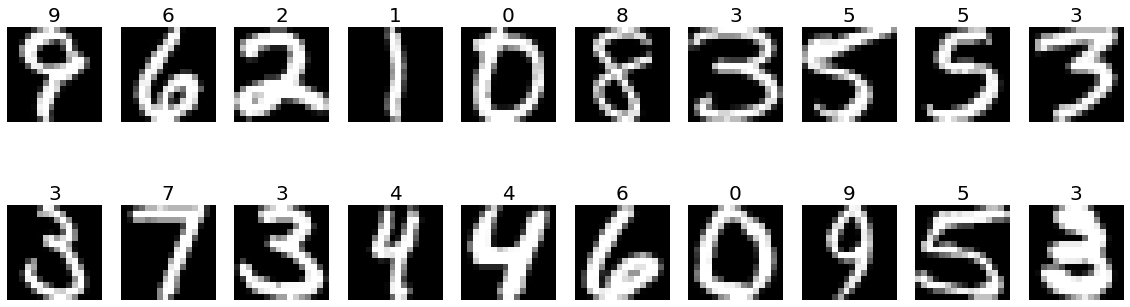

In [8]:
fig = plt.figure(figsize=(20, 6))
for i in range(num_samples):
    ax = plt.subplot(2, 10, i + 1)
    img = sample_digits[i].reshape((16, 16))
    plt.imshow(img, cmap='gray', vmin=-1.0, vmax=1.0)
    plt.axis('off')
    plt.title(int(sample_labels[i]), size=20)

# Implementation With Numpy in procedural way

In [143]:
def find_label(set_x, set_y, point, k):
    '''outputs the kth Nearest neighbour
    i/p 
    set_x: training data
    set_y: training targets
    point : a single data in test set
    k : value for k in k-NN e.g, (1-NN, 2-NN, 3-NN ...)
    '''
    dist = np.linalg.norm(set_x - point, axis =1)
    sorted_index = np.argsort(dist)
    k_list = np.zeros(k)
    for i in range(k):
        k_list[i] = set_y[sorted_index[i]]    
    label = np.argmax(np.bincount(k_list.astype(int)))
    return label

In [64]:
k=1
num_itr = len(y_test)
pred_label = np.zeros(len(y_train)).astype(int)
true_label = np.zeros(len(y_train)).astype(int)
conf_matrix = np.zeros(shape = (10,10))

for i in range(num_itr):
    pred_label[i] = find_label(X_train, y_train, X_test[i], k)
    true_label[i] = int(y_test[i])
    conf_matrix[true_label[i]][pred_label[i]] += 1

print(conf_matrix)

[[355.   0.   2.   0.   0.   0.   0.   1.   0.   1.]
 [  0. 255.   0.   0.   6.   0.   2.   1.   0.   0.]
 [  6.   1. 183.   2.   1.   0.   0.   2.   3.   0.]
 [  3.   0.   2. 154.   0.   5.   0.   0.   0.   2.]
 [  0.   3.   1.   0. 182.   1.   2.   2.   1.   8.]
 [  2.   1.   2.   4.   0. 145.   2.   0.   3.   1.]
 [  0.   0.   1.   0.   2.   3. 164.   0.   0.   0.]
 [  0.   1.   1.   1.   4.   0.   0. 139.   0.   1.]
 [  5.   0.   1.   6.   1.   1.   0.   1. 148.   3.]
 [  0.   0.   1.   0.   2.   0.   0.   4.   1. 169.]]


# With pythonic way in Class structure

In [132]:
class Classifier:
    def score(self, y_prediction, y_test_set):
        return np.mean(y_prediction == y_test_set)
    
    def confusion_matrix(self, y_true, y_predicted):
        size = len(np.unique(y_true)) # or set(y_true)
        conf_matrix = np.zeros((size,size), dtype=np.int32)
        
        for y_label, pred_lable in zip(y_true, y_predicted):
            conf_matrix[int(y_label)][int(pred_lable)] += 1
        
        return conf_matrix

In [133]:
from operator import itemgetter

class KNN(Classifier):
    def __init__(self, k):
        '''initialise 
        k: the number of nearest neighbours to found'''
        self.k = k
        
    def fit(self, set_X, set_y):
        'assigns training set'
        self.set_X = set_X
        self.set_y = set_y
    
    def predict(self, set_X):
        'predicts Nearest Neigbhour list for test dataset'
        return np.array(list(map(self.predict_single, set_X)))
    
    def predict_single(self, x):
        'predicts Nearest Neigbhour for a single data'
        neighbour_count = np.zeros(self.k)
        k_neighbours = self.find_k_closest_neighbours(x)
        
        for i, (candidate_label, distance_) in enumerate(k_neighbours):
            neighbour_count[i] = candidate_label
        
        label = np.argmax(np.bincount(neighbour_count.astype(int)))
        return label
    
    def find_k_closest_neighbours(self, x):
        'returns k closest Neigbhours for a single data with distances'
        distance = np.linalg.norm(self.set_X - x, axis =1)
        candidates = zip(self.set_y, distance)
        closest_points = sorted(candidates, key=itemgetter(1))[:self.k]
        return closest_points
        

In [134]:
knn = KNN(3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [136]:
knn.score(y_pred, y_test)
cm = knn.confusion_matrix(y_test, y_pred)
print(cm)

[[355   0   3   0   0   0   0   0   0   1]
 [  0 258   0   0   3   0   2   1   0   0]
 [  8   0 183   1   1   0   0   2   3   0]
 [  3   0   2 153   0   6   0   1   0   1]
 [  0   2   0   0 183   2   2   2   1   8]
 [  5   0   3   3   0 144   0   0   1   4]
 [  3   1   1   0   2   0 163   0   0   0]
 [  0   1   1   1   4   0   0 138   1   1]
 [  4   0   3   4   0   1   0   1 151   2]
 [  2   0   0   0   3   0   0   4   0 168]]


# Check with sklearn

In [137]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [142]:
KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
score = np.mean(y_pred == y_test)
cm = confusion_matrix(y_test, y_pred)
print("k = {}".format(3))
print("classification score: {}".format(score))
print("confusion matrix: (rows=y_true columns=y_predicted)")
print(pd.DataFrame(cm, index=range(10), columns=range(10)))

k = 3
classification score: 0.9446935724962631
confusion matrix: (rows=y_true columns=y_predicted)
     0    1    2    3    4    5    6    7    8    9
0  355    0    3    0    0    0    0    0    0    1
1    0  258    0    0    3    0    2    1    0    0
2    8    0  183    1    1    0    0    2    3    0
3    3    0    2  153    0    6    0    1    0    1
4    0    2    0    0  183    2    2    2    1    8
5    5    0    3    3    0  144    0    0    1    4
6    3    1    1    0    2    0  163    0    0    0
7    0    1    1    1    4    0    0  138    1    1
8    4    0    3    4    0    1    0    1  151    2
9    2    0    0    0    3    0    0    4    0  168
